_Building something using data?_

The Socrata Open Data API allows you to programmatically access a wealth of open data resources from governments, non-profits, and NGOs around the world.

https://dev.socrata.com/


The *CDC* data is avalable over Socrata API:
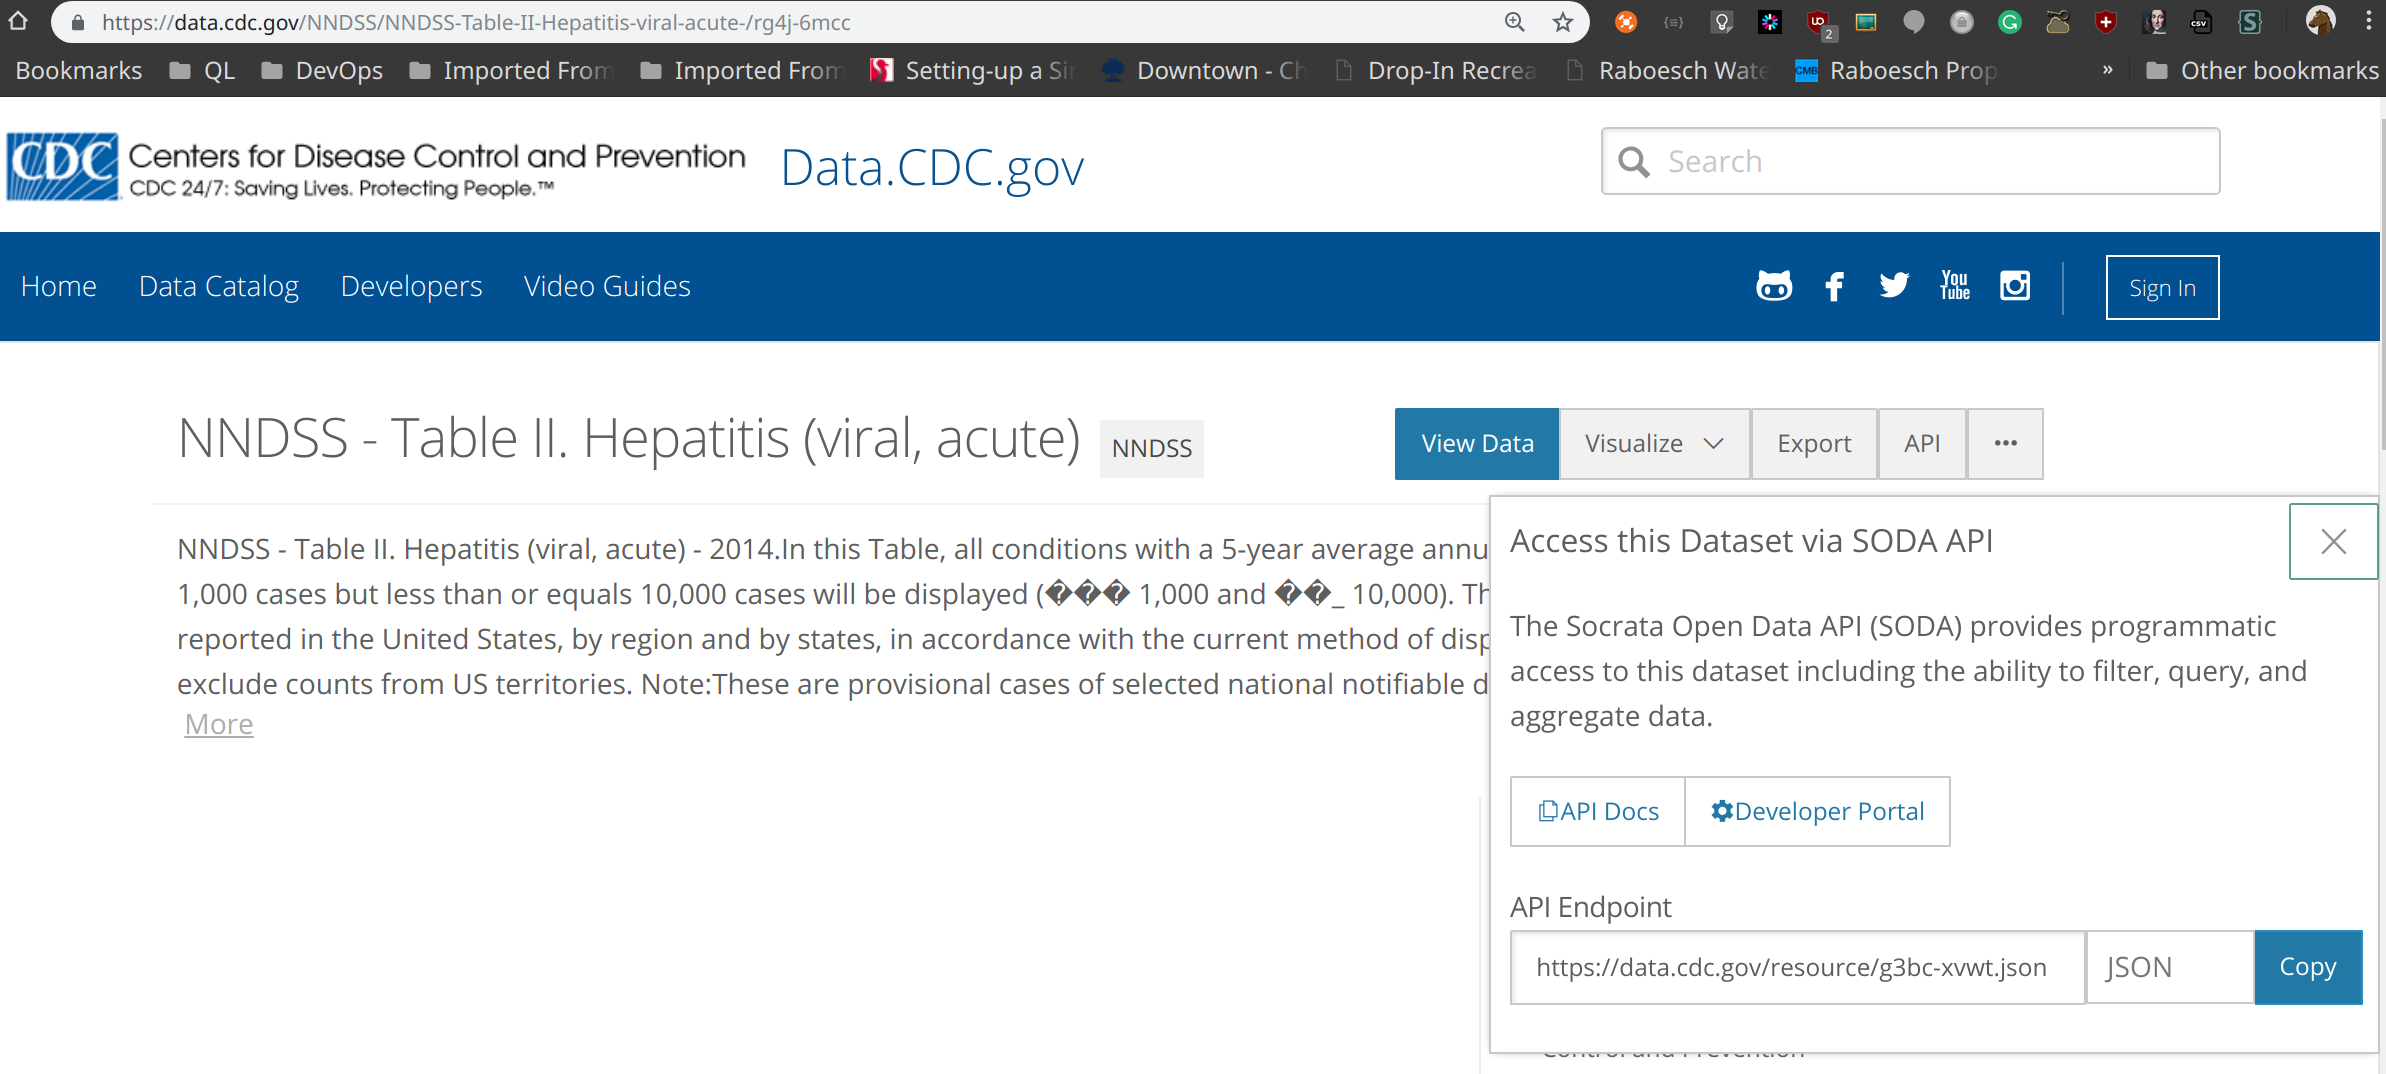




Python bindings for the Socrata Open Data API
* Install sodapy into current notebook environment

In [1]:
import sys
!{sys.executable} -m pip install sodapy
import pandas
import numpy
import os
from sodapy import Socrata
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
plt.close('all')

Define list of datasets to work with by providing Socrata dataset IDs.
The quiry used to find these:
https://healthdata.gov/search/type/dataset?query=2017%20%22Table%20II%22&sort_by=changed&sort_order=DESC&q=search/type/dataset&page=1


In [2]:
datasets = ["rxmp-xjpc","ttj2-zsyk", "i42d-szcv", 
            "6rpz-c2y5", "9qys-crt2","acdz-tk8j", 
            "n24i-76tn", "btcp-84tv", "m6gf-vfkz","5egk-p6rd"]


Connect to the site `"data.cdc.gov"`

In [3]:
client = Socrata("data.cdc.gov", app_token=None)# , os.environ['SOCRATA_TOKEN'])

Define what methadata about columns to print for evaluation

In [4]:
column_properties_we_want_to_see = [
        'dataTypeName',
        'fieldName',
        'width']

All files have these three columns `['reporting_area','mmwr_year','mmwr_week' ]`.

Year is 2018 fo all files. We'll drop the `'mmwr_year'` column while looping over datasets.

Other columns consistently named with most formatted as `decease + measure_name`. The `measure name` usually have a suffix further describing the constract.
 
Example:

* `west_nile_virus_disease_neuroinvasive_previous_52_weeks_max`
* `hepatitis_viral_acute_type_c_previous_52_weeks_med`

Some are informative a very paricular

* `vibriosis_any_species_of_the_family_vibrionaceae_other_than_toxigenic_vibrio_cholerae_o1_or_o139_confirmed_previous_52_weeks_max`


There are plenty of columns having `_flag` postfix having a `'-'` value in it, hence it's useless for the purpose.
The function is created to remove `{..., '<col_name>_flag': 'value', ...}` from record dictionary. The `kv[0]` is a way to refer to a dictionary key. The function is applied to all records of a dataset while looping over datasets.

In [5]:
remove_flags= lambda row: dict(filter(lambda kv: not kv[0].endswith('_flag'), row.items()))

The json numeric data quoted and if converted to DataFrame as is the fiels will be of type Object instead of Number.
```js
{'zika_virus_disease_non_congenital_previous_52_weeks_max': '3', 'west_nile_virus_disease_nonneuroinvasive_previous_52_weeks_med': '0'}
```
The reason apparently stated as to prevent data loss: json Number can interfere with dataset values precision upon cenversion to json. The problem is non particularly relevant to the INT values representing the number of cases but nevertheless need to be delt with. The function that converts field to INT is constructed similar way as remove flags, but `map()` applies the function to all columns of the row if the value `isnumeric()`.  The function is applied to all records of a dataset while looping over datasets.


In [6]:
to_numbers= lambda row: dict(map(lambda kv: (kv[0],int(str(kv[1]))) if str(kv[1]).isnumeric() else kv, row.items()))


We'll aggregate columns from different files by adding on the right where aggregated_by matches.

In [7]:
index_by = ['reporting_area','mmwr_week' ]

Main loop over datasets.
* declare placeholder for aggregation.
* get Metadata, print Name of the Dataset
* iterate over columns, print `column_properties_we_want_to_see`
* fetch and merge data for the four states: 'ILLINOIS','MICHIGAN','OHIO','INDIANA'
  * IMROVMENT - define list of state outside of the loop to have more states
* read data into DataFrame, drop index and `mmwr_year` column, location colums (cause the dataset is per state the location is for the state and same for all records)
* fill NaN with 0
* the expected shape is 208 records: 52 weeks X 4 states. Try to remove duplicates and report errors if there are still more then 208.
* print dataset tags
* Correctly handle empty placeholder for the first dataset.
* On second and subsequent loop cycles merge columns by `'reporting_area' and 'mmwr_week'` expanding dataset by adding columns with data to the right.
* set index to `['reporting_area', 'mmwr_week']` columns
* print the shape of the final dataframe

In [8]:
union_of_all_files_df= None

for dataset in datasets:
    metadata= client.get_metadata(dataset)
    print(metadata['name'])
    all_metadata_about_columns = metadata['columns']
    for a_meta in all_metadata_about_columns:
        out=""
        for meta_key, meta_value in a_meta.items():
            if meta_key in column_properties_we_want_to_see:
                #out+=meta_key
                #out+=" => "
                out+=str(meta_value)
                out+=", "
        if out:
            print(out)
            print('--------------------------')

    il= client.get(dataset, reporting_area='ILLINOIS')
    #print(il)
    mi= client.get(dataset, reporting_area='MICHIGAN')
    oh= client.get(dataset, reporting_area='OHIO')
    ind= client.get(dataset, reporting_area='INDIANA')
    states=il+mi+oh+ind
    all_ = list(map(remove_flags, states))
    all__ = list(map(to_numbers, all_))
    print("Four states dataset has: ",len(all__), " records")
    current_df= pandas.io.json.json_normalize(all__)
    if 'location_1.human_address' in current_df.columns:
        current_df.drop(['location_1.human_address'
                     ,'location_1.latitude'
                     ,'location_1.longitude'
                     ,'location_1.needs_recoding'], axis=1, inplace=True)
    if 'location_2.human_address' in current_df.columns:
        current_df.drop(['location_2.human_address'
                     ,'location_2.latitude'
                     ,'location_2.longitude'
                     ,'location_2.needs_recoding'], axis=1, inplace=True) 
    current_df.fillna(value= 0, inplace=True)
    if len(all__) > 208:
        print("!!! Potential ERROR!!! dataset has: ",len(all__), " records while 208 (4 states X 52 weeks each) is expected!!!")
        current_df.drop_duplicates(keep= 'first', inplace= True)
        print("Taking a first duplicate! data frame shape is: ",current_df.shape," now")
        if current_df.shape[0] > 208:
            print("STILL DUPLICATES: ",current_df.shape," now")
            print("DUPLICATES", *current_df.get_values())
        
    current_df.reset_index()
    current_df.drop('mmwr_year', axis=1, inplace=True)

    print("Tags",client.get_metadata(dataset)['tags'])
    if union_of_all_files_df is not None:
        union_of_all_files_df = union_of_all_files_df.merge(current_df
                                    , on= index_by)
        
    else:
        union_of_all_files_df = current_df
        current_df = None
        print("Init done ")          
        
union_of_all_files_df.set_index(index_by,inplace=True)
print(union_of_all_files_df.shape)

NNDSS - Table II. West Nile to Zika
text, reporting_area, 167, 
--------------------------
number, mmwr_year, 158, 
--------------------------
number, mmwr_week, 161, 
--------------------------
number, west_nile_virus_disease_neuroinvasive_current_week, 388, 
--------------------------
text, west_nile_virus_disease_neuroinvasive_current_week_flag, 418, 
--------------------------
number, west_nile_virus_disease_neuroinvasive_previous_52_weeks_med, 447, 
--------------------------
text, west_nile_virus_disease_neuroinvasive_previous_52_weeks_med_flag, 470, 
--------------------------
number, west_nile_virus_disease_neuroinvasive_previous_52_weeks_max, 447, 
--------------------------
text, west_nile_virus_disease_neuroinvasive_previous_52_weeks_max_flag, 468, 
--------------------------
number, west_nile_virus_disease_neuroinvasive_cum_2018, 373, 
--------------------------
text, west_nile_virus_disease_neuroinvasive_cum_2018_flag, 398, 
--------------------------
number, west_nile_vir

Four states dataset has:  208  records
Tags ['2018', 'nndss', 'wonder', 'nedss', 'netss', 'tetanus', 'varicella morbidity']
NNDSS - Table II. Salmonellosis (excluding typhoid fever and paratyphoid fever) to Shigellosis
text, reporting_area, 166, 
--------------------------
number, mmwr_year, 155, 
--------------------------
number, mmwr_week, 170, 
--------------------------
number, salmonellosis_excluding_paratyphoid_fever_andtyphoid_fever_current_week, 517, 
--------------------------
text, salmonellosis_excluding_paratyphoid_fever_andtyphoid_fever_current_week_flag, 545, 
--------------------------
number, salmonellosis_excluding_paratyphoid_fever_andtyphoid_fever_previous_52_weeks_med, 575, 
--------------------------
text, salmonellosis_excluding_paratyphoid_fever_andtyphoid_fever_previous_52_weeks_med_flag, 613, 
--------------------------
number, salmonellosis_excluding_paratyphoid_fever_andtyphoid_fever_previous_52_weeks_max, 576, 
--------------------------
text, salmonellosis

--------------------------
location, location_2, 154, 
--------------------------
Four states dataset has:  224  records
!!! Potential ERROR!!! dataset has:  224  records while 208 (4 states X 52 weeks each) is expected!!!
Taking a first duplicate! data frame shape is:  (216, 13)  now
STILL DUPLICATES:  (216, 13)  now
DUPLICATES [0.0 0.0 0.0 0 0 0.0 0.0 0.0 0 0 1 2018 'ILLINOIS'] [0.0 0.0 0.0 0 0 0.0 0.0 0.0 0 0 2 2018 'ILLINOIS'] [0.0 0.0 0.0 0 0 0.0 0.0 0.0 0 0 3 2018 'ILLINOIS'] [0.0 0.0 0.0 0 0 0.0 0.0 0.0 0 0 4 2018 'ILLINOIS'] [0.0 0.0 0.0 0 0 0.0 0.0 0.0 0 0 5 2018 'ILLINOIS'] [0.0 0.0 0.0 0 0 0.0 0.0 0.0 0 0 6 2018 'ILLINOIS'] [0.0 0.0 0.0 0 0 0.0 0.0 0.0 0 0 7 2018 'ILLINOIS'] [0.0 0.0 0.0 0 0 0.0 0.0 0.0 0 0 8 2018 'ILLINOIS'] [0.0 0.0 0.0 0 0 0.0 0.0 0.0 0 0 9 2018 'ILLINOIS'] [0.0 0.0 0.0 0 0 0.0 0.0 0.0 0 0 10 2018 'ILLINOIS'] [0.0 0.0 0.0 0 0 0.0 0.0 0.0 0 0 11 2018 'ILLINOIS'] [0.0 0.0 0.0 0 0 0.0 0.0 0.0 0 0 12 2018 'ILLINOIS'] [0.0 0.0 0.0 0 0 0.0 0.0 0.0 0 0 13 2018 '

NNDSS - Table II. Hepatitis (viral, acute, by type) A & B
text, reporting_area, 165, 
--------------------------
number, mmwr_year, 154, 
--------------------------
number, mmwr_week, 164, 
--------------------------
number, hepatitis_viral_acute_by_type_a_current_week, 360, 
--------------------------
text, hepatitis_viral_acute_by_type_a_current_week_flag, 381, 
--------------------------
number, hepatitis_viral_acute_by_type_a_previous_52_weeks_med, 415, 
--------------------------
text, hepatitis_viral_acute_by_type_a_previous_52_weeks_med_flag, 442, 
--------------------------
number, hepatitis_viral_acute_by_type_a_previous_52_weeks_max, 414, 
--------------------------
text, hepatitis_viral_acute_by_type_a_previous_52_weeks_max_flag, 440, 
--------------------------
number, hepatitis_viral_acute_by_type_a_cum_2018, 337, 
--------------------------
text, hepatitis_viral_acute_by_type_a_cum_2018_flag, 369, 
--------------------------
number, hepatitis_viral_acute_by_type_a_cum_201

Print agregated dataset columns:

In [9]:
print("Columns ",*union_of_all_files_df.columns, sep='\n')

Columns 
west_nile_virus_disease_neuroinvasive_cum_2017
west_nile_virus_disease_neuroinvasive_cum_2018
west_nile_virus_disease_neuroinvasive_current_week
west_nile_virus_disease_neuroinvasive_previous_52_weeks_max
west_nile_virus_disease_neuroinvasive_previous_52_weeks_med
west_nile_virus_disease_nonneuroinvasive_cum_2017
west_nile_virus_disease_nonneuroinvasive_cum_2018
west_nile_virus_disease_nonneuroinvasive_current_week
west_nile_virus_disease_nonneuroinvasive_previous_52_weeks_max
west_nile_virus_disease_nonneuroinvasive_previous_52_weeks_med
zika_virus_disease_non_congenital_cum_2017
zika_virus_disease_non_congenital_cum_2018
zika_virus_disease_non_congenital_previous_52_weeks_max
zika_virus_disease_non_congenital_previous_52_weeks_med
vibriosis_any_species_of_the_family_vibrionaceae_other_than_toxigenic_vibrio_cholerae_o1_or_o139_confirmed_cum_2017
vibriosis_any_species_of_the_family_vibrionaceae_other_than_toxigenic_vibrio_cholerae_o1_or_o139_confirmed_cum_2018
vibriosis_any_sp

Save results to csv file

In [10]:
file= open('result.csv','w')
union_of_all_files_df.to_csv(file)
file.close()

Construct dataframe with `cumulative` data by week: cumulative number of cases groing as week number increases.

In [11]:
cums = union_of_all_files_df.filter(regex='cum', axis= 'columns')
print("Shape of Cummulatives", cums.shape)


Shape of Cummulatives (216, 47)


In [12]:
cums.columns

Index(['west_nile_virus_disease_neuroinvasive_cum_2017',
       'west_nile_virus_disease_neuroinvasive_cum_2018',
       'west_nile_virus_disease_nonneuroinvasive_cum_2017',
       'west_nile_virus_disease_nonneuroinvasive_cum_2018',
       'zika_virus_disease_non_congenital_cum_2017',
       'zika_virus_disease_non_congenital_cum_2018',
       'vibriosis_any_species_of_the_family_vibrionaceae_other_than_toxigenic_vibrio_cholerae_o1_or_o139_confirmed_cum_2017',
       'vibriosis_any_species_of_the_family_vibrionaceae_other_than_toxigenic_vibrio_cholerae_o1_or_o139_confirmed_cum_2018',
       'vibriosis_any_species_of_the_family_vibrionaceae_other_than_toxigenic_vibrio_cholerae_o1_or_o139_probable_cum_2017',
       'vibriosis_any_species_of_the_family_vibrionaceae_other_than_toxigenic_vibrio_cholerae_o1_or_o139_probable_cum_2018',
       'tetanus_cum_2017', 'tetanus_cum_2018', 'varicella_cum_2017',
       'varicella_cum_2018',
       'salmonellosis_excluding_paratyphoid_fever_andtyphoid

Split cumulatives dataset into four by state: 

In [13]:
group_by_state = cums.groupby(by='reporting_area')

Plot one legend and four plots

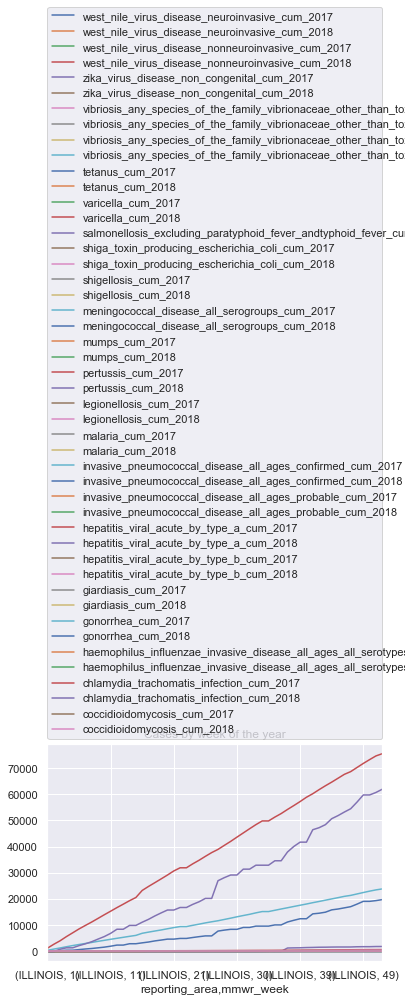

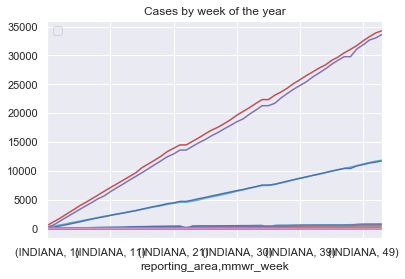

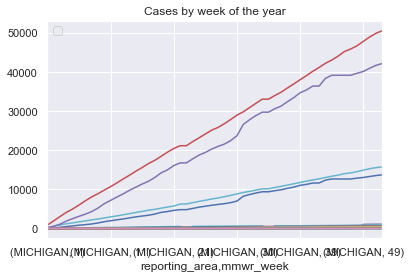

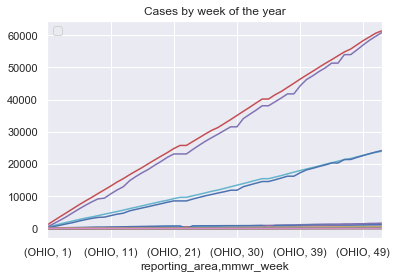

In [14]:
axis = group_by_state.plot(kind='line', title="Cases by week of the year")
one= True
for ax in axis:
    if one:
        ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0)
        one= False
    else:
        ax.legend([])


Find maximums for cummulative data fro MI that should be a 52d week number. 
Print bar chart

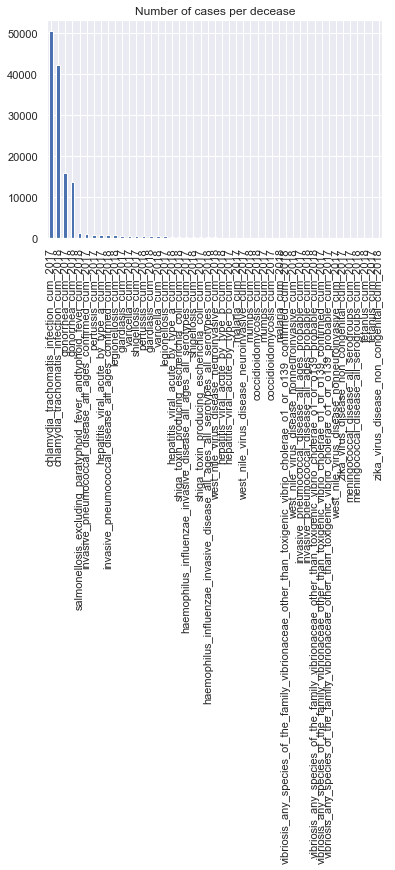

In [15]:
mi_cums= cums.loc['MICHIGAN']
sorted= mi_cums.max().sort_values(ascending= False)
axes= sorted.plot(kind="bar", title="Number of cases per decease")

Print top 8

In [16]:
sorted[0:7]

chlamydia_trachomatis_infection_cum_2017                               50595.0
chlamydia_trachomatis_infection_cum_2018                               42201.0
gonorrhea_cum_2017                                                     15742.0
gonorrhea_cum_2018                                                     13713.0
salmonellosis_excluding_paratyphoid_fever_andtyphoid_fever_cum_2018     1076.0
invasive_pneumococcal_disease_all_ages_confirmed_cum_2017                927.0
pertussis_cum_2017                                                       744.0
dtype: float64

Observations:

* Chlamydia trachomatis is about 3 times more often then Gonorrhea
* Both have decreased from 2017 to 2018
* Both are way ahead of every other ones!
* Next one is salmonellosis and still 10 time less often

Maslow is wrong: sex is more important then food.

Get data for "current_week" for all deseases, aggregate for all states, print shape.
Plot N

(52, 23)


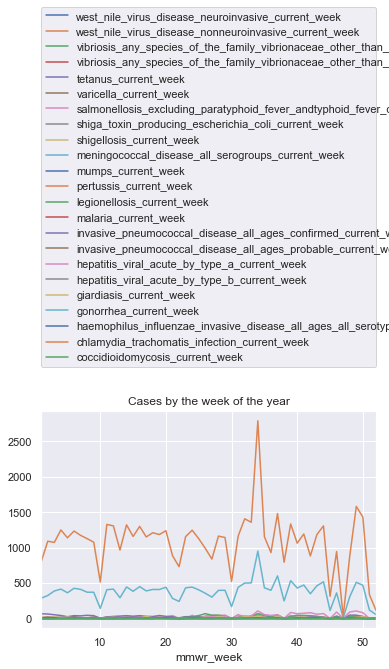

In [17]:
current_week_= union_of_all_files_df.filter(regex='current_week', axis= 'columns')
current_week= current_week_.groupby(level='mmwr_week').sum() # 'reporting_area','mmwr_year'
print(current_week.shape)
axis = current_week.plot(kind='line', title="Cases by the week of the year")
axis.legend(bbox_to_anchor=(0,1.2,1,0.5), loc="lower left",
                mode="expand", borderaxespad=0)


Observations
* Chlamydia rates picks at end of summer and winter holidays
Print descriptive statistics of weekly fluctiatons.

In [18]:
current_week.describe()


,west_nile_virus_disease_neuroinvasive_current_week,west_nile_virus_disease_nonneuroinvasive_current_week,vibriosis_any_species_of_the_family_vibrionaceae_other_than_toxigenic_vibrio_cholerae_o1_or_o139_confirmed_current_week,vibriosis_any_species_of_the_family_vibrionaceae_other_than_toxigenic_vibrio_cholerae_o1_or_o139_probable_current_week,tetanus_current_week,varicella_current_week,salmonellosis_excluding_paratyphoid_fever_andtyphoid_fever_current_week,shiga_toxin_producing_escherichia_coli_current_week,shigellosis_current_week,meningococcal_disease_all_serogroups_current_week,...,malaria_current_week,invasive_pneumococcal_disease_all_ages_confirmed_current_week,invasive_pneumococcal_disease_all_ages_probable_current_week,hepatitis_viral_acute_by_type_a_current_week,hepatitis_viral_acute_by_type_b_current_week,giardiasis_current_week,gonorrhea_current_week,haemophilus_influenzae_invasive_disease_all_ages_all_serotypes_current_week,chlamydia_trachomatis_infection_current_week,coccidioidomycosis_current_week
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,...,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,0.057692,0.019231,0.500000,0.557692,0.038462,10.615385,19.903846,9.807692,8.961538,0.173077,...,0.846154,21.769231,0.653846,26.461538,2.673077,9.442308,378.730769,4.500000,1078.307692,0.346154
std,0.307645,0.138675,1.146179,1.109910,0.194184,6.466062,19.381879,8.099960,5.597484,0.430283,...,0.997735,16.790071,0.813721,32.859452,2.220415,8.381617,146.135864,3.152963,408.866273,0.837471
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,27.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,4.000000,5.750000,0.000000,...,0.000000,9.750000,0.000000,2.000000,1.000000,3.500000,318.750000,2.750000,918.250000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,20.000000,9.000000,9.500000,0.000000,...,0.500000,17.000000,0.000000,7.000000,2.000000,6.000000,400.000000,4.500000,1152.000000,0.000000
75%,0.000000,0.000000,0.250000,1.000000,0.000000,15.250000,35.000000,13.250000,11.000000,0.000000,...,2.000000,33.750000,1.000000,48.250000,4.000000,12.000000,440.500000,6.250000,1246.000000,0.000000
max,2.000000,1.000000,6.000000,6.000000,1.000000,28.000000,68.000000,34.000000,24.000000,2.000000,...,4.000000,66.000000,3.000000,106.000000,8.000000,32.000000,950.000000,14.000000,2790.000000,5.000000


Get 4 deseases and computte correlations: 
"chlamydia_trachomatis_infection_current_week","gonorrhea_current_week","salmonellosis_excluding_paratyphoid_fever_andtyphoid_fever_current_week","invasive_pneumococcal_disease_all_ages_confirmed_current_week"

In [19]:
four_tu_corr= current_week.filter(["chlamydia_trachomatis_infection_current_week",
                     "gonorrhea_current_week",
                     "salmonellosis_excluding_paratyphoid_fever_andtyphoid_fever_current_week",
                     "invasive_pneumococcal_disease_all_ages_confirmed_current_week"])

In [20]:
#four_tu_corr
four_tu_corr.corr(min_periods=2)

,chlamydia_trachomatis_infection_current_week,gonorrhea_current_week,salmonellosis_excluding_paratyphoid_fever_andtyphoid_fever_current_week,invasive_pneumococcal_disease_all_ages_confirmed_current_week
chlamydia_trachomatis_infection_current_week,1.000000,0.973584,0.506662,0.265459
gonorrhea_current_week,0.973584,1.000000,0.572126,0.180075
salmonellosis_excluding_paratyphoid_fever_andtyphoid_fever_current_week,0.506662,0.572126,1.000000,-0.170285
invasive_pneumococcal_disease_all_ages_confirmed_current_week,0.265459,0.180075,-0.170285,1.000000


Draw correlation between the ususal suspects

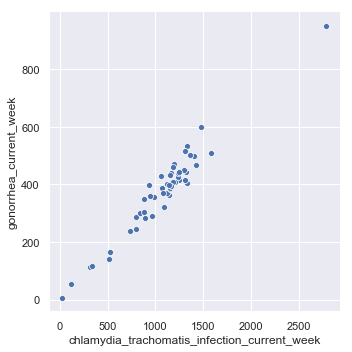

In [21]:
sns.relplot(x="chlamydia_trachomatis_infection_current_week", y="gonorrhea_current_week", data=four_tu_corr);

Not so much correlation is found between "gonorrhea_current_week" and "salmonellosis_excluding_paratyphoid_fever_andtyphoid_fever_current_week

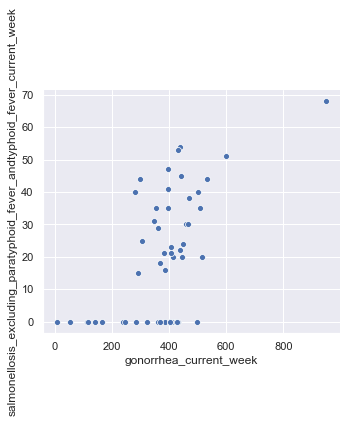

In [22]:
sns.relplot(x="gonorrhea_current_week", y="salmonellosis_excluding_paratyphoid_fever_andtyphoid_fever_current_week", data=four_tu_corr);

Let's explore if there is correlations betweel less frequent deceises.

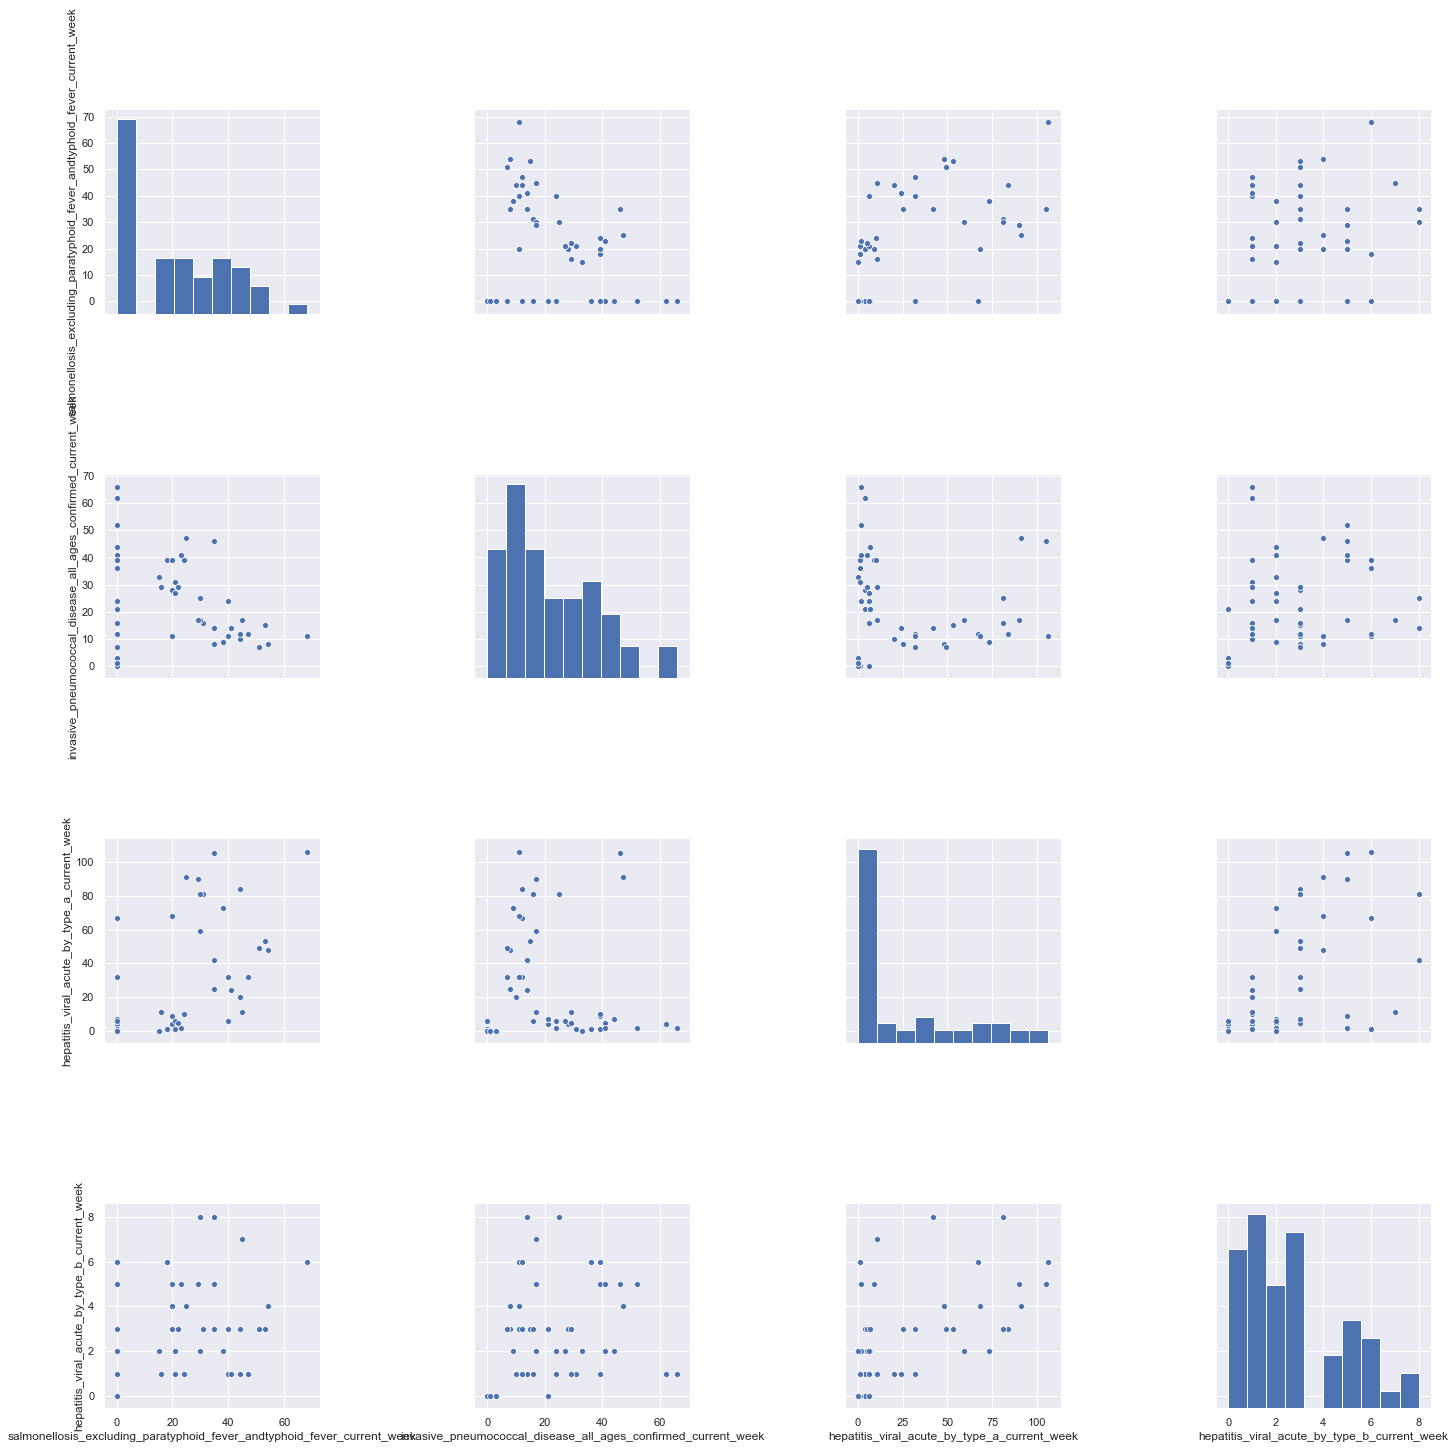

In [23]:
less_freq_= current_week.filter(regex='(salmonellosis_excluding_paratyphoid_fever_andtyphoid_fever_current_week|invasive_pneumococcal_disease_all_ages_confirmed_current_week|hepatitis_viral_acute_by_type_a_current_week|hepatitis_viral_acute_by_type_b_current_week)', axis= 'columns')
less_freq= less_freq_.groupby(level='mmwr_week').sum() # 'reporting_area','mmwr_year'
sns.pairplot(less_freq, height=5);


There are some correlations to discover! Possible one between:  hepatitis_viral_acute_by_type_a_current_week & invasive_pneumococcal_disease_all_ages_confirmed_current_week

Conlcusuons:
* Venerial deseases are stil prevalent
* Salmonella is the next
* Other more dangerous ones are rare compare to the leaders
* west nile is less frequent then the number of times the word itself mentioned by the press. 